# Introduction

**B**ayesian **I**nferential **R**egression for **D**ifferential **M**icrobiome **A**nalysis (BIRDMAn) is a WIP tool for flexible differential abundance analysis through Bayesian inference. BIRDMAn is unique in that it has been designed to support custom statistical modelling. Other tools implement specific models designed for general use cases. BIRDMAn, on the other hand, makes use of the [Stan](https://mc-stan.org/) probabilistic programming language for model specification. The overall goal of this software is to allow users to specify their own statistical models to address their individual experimental design/questions.

BIRDMAn also includes several default models for those who do not wish to tinker with custom Stan models. In this demo notebook, we'll walkthrough fitting the default Negative Binomial model to some example data. For more information see Jamie's [blogpost](https://mortonjt.github.io/probable-bug-bytes/probable-bug-bytes/differential-abundance/) that inspired this project.

**NOTE:** BIRDMAn is still in development and things are likely to change.

# Quick primer on Bayesian inference

Bayesian inference is a technique to learn about a given population through Bayes' Theorem. Given data, $D$, and parameter(s), $\theta$, Bayes' Theorem applies as follows:

$$ P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)} $$

The component parts of this formula are usually described with the following terms:

* $P(\theta)$: *prior* - our "current" knowledge of $\theta$ independent of our data
* $P(D|\theta)$: *likelihood* - how likely is the data given our knowledge of the parameters?
* $P(\theta|D)$: *posterior* - the "updated" knowledge of $\theta$ after seeing the data
* $P(D)$: *evidence* - the probability of the data over all values of $\theta$

Our goal is to hone in on values of $\theta$ that best fit the data according to some statistical model we specify. Importantly, we do so by providing both the *data generative model* and the *prior distribution* of the parameters.

## Sampling from the posterior distribution

One of the biggest hurdles to Bayesian inference is that computing $P(\theta|D)$ is *hard* and more often than not unattainable via analytic methods. To address this, scientists often use *Markov Chain Monte Carlo* (MCMC) methods. In a nutshell, MCMC uses dependent sampling of a distribution to attempt convergence around some parameter estimate.

The core of BIRDMAn is using Stan to perform multivariate regression on count data to determine which biological features are changing with respect to your covariates of interest. We wrap a lot of this integration into an easy-to-use Python package that is both flexible and extensible.

# Example usage

## Dataset

We will be using data from the study **"Responses of gut microbiota to diet composition and weight loss in lean and obese mice" (Qiita ID: 107)**. This study looks at the effect of weight loss and diet composition on the gut microbiome.

We will first process and explore the raw data.

In [1]:
from birdman import __version__
print(__version__)

0.1.0


/home/grahman/miniconda3/envs/birdman-demo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use("./plot.mplstyle")

In [3]:
import biom

raw_tbl = biom.load_table("../data/lean_obese_mice/44773_otu_table.biom")
raw_tbl

1932 x 29 <class 'biom.table.Table'> with 9055 nonzero entries (16% dense)

In [4]:
raw_tbl_df = raw_tbl.to_dataframe()
raw_tbl_df.iloc[:5, :5]

,107.CM04,107.CM10,107.CM19,107.CM23,107.CM28
206494,1.0,3.0,14.0,5.0,1.0
261725,0.0,0.0,0.0,0.0,0.0
276620,2.0,9.0,2.0,2.0,0.0
296165,2.0,0.0,0.0,0.0,0.0
389067,0.0,0.0,0.0,0.0,0.0


For this demo we are going to use a small subset of the OTUs present in this table based on prevalence (present in at least 20 samples). This is done primarily to let the models run quickly.

In [5]:
prev = raw_tbl_df.clip(upper=1).sum(axis=1)
filt_tbl_df = raw_tbl_df.loc[prev[prev >= 20].index, :]
filt_tbl_df.shape

(77, 29)

BIRDMAn expects tables to be input in BIOM format so we save our filtered table in this format.

In [6]:
filt_tbl = biom.table.Table(
    filt_tbl_df.values,
    sample_ids=filt_tbl_df.columns,
    observation_ids=filt_tbl_df.index
)
filt_tbl

77 x 29 <class 'biom.table.Table'> with 1789 nonzero entries (80% dense)

## Exploring metadata

Given the title of this study, we are going to be focused on weight loss and diet as covariates in our model.

In [7]:
import pandas as pd

metadata = pd.read_csv(
    "../data/lean_obese_mice/107_20180101-113755.txt",
    sep="\t",
    index_col=0
)
metadata.index = metadata.index.astype(str)
metadata.head()

,adiponectin,altitude,anonymized_name,b_cell_function_measure,body_habitat,body_product,body_site,body_weight,cd11c,collection_date,...,saa3,sample_type,slc25a,t3,t4,title,tnfa,total_ee,total_number_of_synapses,treatment
sample_name,,,,,,,,,,,,,,,,,,,,,
107.CM01,44.03,0,sample01,154.5,UBERON:feces,UBERON:feces,UBERON:feces,30.6,0.60,11/8/11,...,0.08,XXQIITAXX,0.85,72.86,45.06,Leptin levels correlate with the composition o...,1.51,10.60,23.29,Weight Reduced
107.CM02,44.16,0,sample09,200.6,UBERON:feces,UBERON:feces,UBERON:feces,52.0,1.86,11/8/11,...,1.62,XXQIITAXX,1.07,13.60,33.96,Leptin levels correlate with the composition o...,1.30,13.80,NaN,Ad Lib
107.CM03,39.17,0,sample02,133.3,UBERON:feces,UBERON:feces,UBERON:feces,29.3,1.01,11/8/11,...,0.10,XXQIITAXX,1.14,7.76,45.12,Leptin levels correlate with the composition o...,1.82,10.23,18.40,Weight Reduced
107.CM04,23.55,0,sample03,280.7,UBERON:feces,UBERON:feces,UBERON:feces,36.1,0.53,11/8/11,...,2.24,XXQIITAXX,1.01,15.30,57.87,Leptin levels correlate with the composition o...,1.17,11.70,19.06,Weight Reduced
107.CM05,28.33,0,sample10,472.9,UBERON:feces,UBERON:feces,UBERON:feces,52.9,1.14,11/8/11,...,3.83,XXQIITAXX,1.55,33.46,52.03,Leptin levels correlate with the composition o...,0.62,16.06,26.44,Ad Lib


In [8]:
metadata.groupby(["diet", "treatment"]).size()

diet     treatment     
Control  Ad Lib            8
         Weight Reduced    8
DIO      Ad Lib            7
         Weight Reduced    8
dtype: int64

We will consider diet, treatment, and their interaction in our regression model. Importantly, we will specify that we want to keep `Control` and `Ad Lib` as the respective reference values (same way as in Songbird).

## Running BIRDMAn

Now it's time to run BIRDMAn! A crucial step is determining which data generative model to use. We have designed BIRDMAn to accept Stan files containing model specification. However, we recognize that many users will not need or want to write their own Stan code. For this reason, we have included a number of default models that can be fit without writing any Stan code. In this notebook we make use of the negative binomial distribution as it is [common for overdispersed count data](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/10-1831.1). We also include the multinomial distribution (same as in Songbird) and are planning to include the Poisson log-normal distribution.

### Negative binomial model

The negative binomial model can be thought of as an extension of the Poisson model that takes overdispersion into account.

For a given sample, $i$ and microbe $j$, the associated feature table entry is modeled as:

$$ y_{ij} \sim \textrm{NB}(\mu_{ij}, \phi_j)$$

where $\mu_{ij}$ is the expected abundance and $\phi_j$ represents the dispersion parameter associated with microbe $j$. We then model $\mu_{ij}$ as a function of the sampling depth of sample $i$ and the probability of $ij$.

$$ \mu_{ij} = n_{i}p_{ij} $$

The probability of microbe $j$ in sample $i$ is modeled by the inverse additive log-ratio (ALR).

$$ p_{ij} = \textrm{alr}^{-1}(x_i\beta) $$

$x_i$ represents your specified covariates and $\beta$ represents their associated coefficients (differentials). In the negative binomial model we are primarily interested in specifying covariates and estimating which values of $\beta$ are most plausible given our data.

Finally, as mentioned above we have to integrate our prior knowledge of our parameters $\beta$ and $\phi$. By default we use a normally distributed $\beta$ with a mean of 0 and user-specified standard deviation (defaults to 5) and a lognormally distributed reciprocal $\phi$ with location 0 and user-specified scale parameter (defaults to 5).

$$ \beta \sim \mathcal{N}(0, B_p) $$

$$ \frac{1}{\phi} \sim \textrm{Lognormal}(0, s) $$

For more details on this model see Jamie's excellent [blogpost](https://mortonjt.github.io/probable-bug-bytes/probable-bug-bytes/differential-abundance/).

### Input parameters

Every BIRDMAn model takes several parameters that I will outline here:

* `table`: BIOM table of features x samples
* `formula`: Formula with which to fit model (same as in Songbird)
* `metadata`: DataFrame with columns specified in `formula`
* `num_iter`: Number of iterations of MCMC sampling to run *per chain*
* `chains`: Number of chains to run

Each BIRDMAn model also expects the priors to be input by the user. For the negative binomial model these are referred to as `beta_prior` and `inv_disp_sd`.

To save on computation time we will only specify 100 iterations per chain. In an actual analysis you will likely need to increase this number (defaults to 500).

In [9]:
from birdman import NegativeBinomial

nb = NegativeBinomial(
    table=filt_tbl,
    formula="C(diet, Treatment('Control'))*C(treatment, Treatment('Ad Lib'))",
    metadata=metadata,
    num_iter=100,
    chains=4,
    beta_prior=3.0,
    inv_disp_sd=0.5
)

The Stan model must be compiled before fitting. This should only have to be done once *per model type*. So the second time you use the default `NegativeBinomial` model it will not have to compile.

In [10]:
nb.compile_model()

Finally, we'll fit the model to our data. This should take ~1.5 minute.

In [11]:
%%time

import logging

cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

nb.fit_model()

chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 3 |██▌       | 00:00 Status
chain 2 |██▌       | 00:00 Status


chain 4 |██▌       | 00:00 Status


chain 4 |█████     | 00:36 Iteration:   1 / 200 [  0%]  (Warmup)

chain 3 |█████     | 00:36 Iteration:   1 / 200 [  0%]  (Warmup)
chain 2 |█████     | 00:36 Iteration:   1 / 200 [  0%]  (Warmup)


chain 4 |███████▌  | 00:36 Iteration: 100 / 200 [ 50%]  (Warmup)

chain 3 |███████▌  | 00:37 Iteration: 100 / 200 [ 50%]  (Warmup)
chain 1 |███████▌  | 00:37 Iteration: 100 / 200 [ 50%]  (Warmup)


chain 4 |██████████| 01:14 Iteration: 101 / 200 [ 50%]  (Sampling)

chain 3 |██████████| 01:14 Iteration: 101 / 200 [ 50%]  (Sampling)
chain 1 |██████████| 01:16 Sampling completed                     
chain 2 |██████████| 01:16 Sampling completed                     
chain 3 |██████████| 01:16 Sampling completed                     
chain 4 |██████████| 0


CPU times: user 257 ms, sys: 55.3 ms, total: 313 ms
Wall time: 1min 16s


## Data structure for model

BIRDMAn makes heavy use of the `arviz` package for downstream analysis (see [documentation](https://arviz-devs.github.io/arviz/index.html)). We provide a wrapper function `to_inference` to make this relatively easy.

This function wraps much of the functionality of `xarray` for multi-dimensional arrays (see [documentation](http://xarray.pydata.org/en/stable/)).

In [12]:
inference = nb.to_inference()

## Diagnosing our fitted model

As with Songbird (or any regression/ML procedure) we want to diagnose our model to make sure we are extracting useful signal and not simply overfitting predictive power. There are a number of ways to do this.

### LOO

Next we look at the Pareto-smoothed Importance Sampling Leave-One-Out Cross-Validation (PSIS-LOO-CV). This is a mouthful but the core of it is that we want to cross-validate our model to make sure we are not overfitting. This can be fairly computationally expensive for Bayesian models so we use an estimation developed by Aki Vehtari and others. This way we can estimate model performance *from the existing sample draws*.

See these two papers for more information:

* https://arxiv.org/abs/1507.04544
* https://arxiv.org/abs/1507.02646

**Note:** This function requires that you calculated the `log likelihood` values in your Stan code (done by the default Negative Binomial model) and passed them to the inference object.

In [13]:
import birdman.diagnostics as diag

diag.loo(inference, pointwise=True)

Computed from 400 posterior samples and 2233 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -8057.05   104.66
p_loo      318.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2005   89.8%
 (0.5, 0.7]   (ok)        159    7.1%
   (0.7, 1]   (bad)        59    2.6%
   (1, Inf)   (very bad)   10    0.4%

Log likelihood is calculated for each entry in your input table - essentially figuring out how likely is the table value given the estimated parameters. We want to maximize the `elpd_loo` entry. In this demonstration we also calculate the *pointwise* predictive accuracy. We want to see the majority of the Pareto k diagnostic values < 0.7. If there are a lot of values above 0.7 this is indicative of a relatively poor model.

### $\hat{R}$ convergence

Another diagnostic tool is making sure your chains are converging. This can be done by checking the $\hat{R}$ values of your fitted parameters. In a nutshell, these values should be extremely close to 1 to ensure convergence.

See [this link](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html) for more details. 

In [14]:
diag.rhat(inference).max()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    inv_disp  float64 1.04
    beta_var  float64 1.041

We see that across both our covariate coefficients and overdispersion parameters our chains have converged well.

### Posterior predictive check

We can do some more diagnosing by performing a *Posterior Predictive Check*. This procedure essentially uses the parameter distributions we've estimated and tries to predict our original values. We've provided an easy-to-use visualization function that performs this for you. This figure plots the individual table entries (samples x features) and how our model predictions fall. The black line represents the true value, the light gray vertical lines represent the middle 95% interval of values, and the dark gray dots represent the median values from all chains/iterations. We want to see the dark gray lines more-or-less follow the same shape as the black line. It is also preferable to have small credible intervals but predicting microbiome data is very difficult so it is expected that these intervals will be fairly large.

Note that this requires posterior predictive values to have been calculated in Stan and provided to `to_inference`.

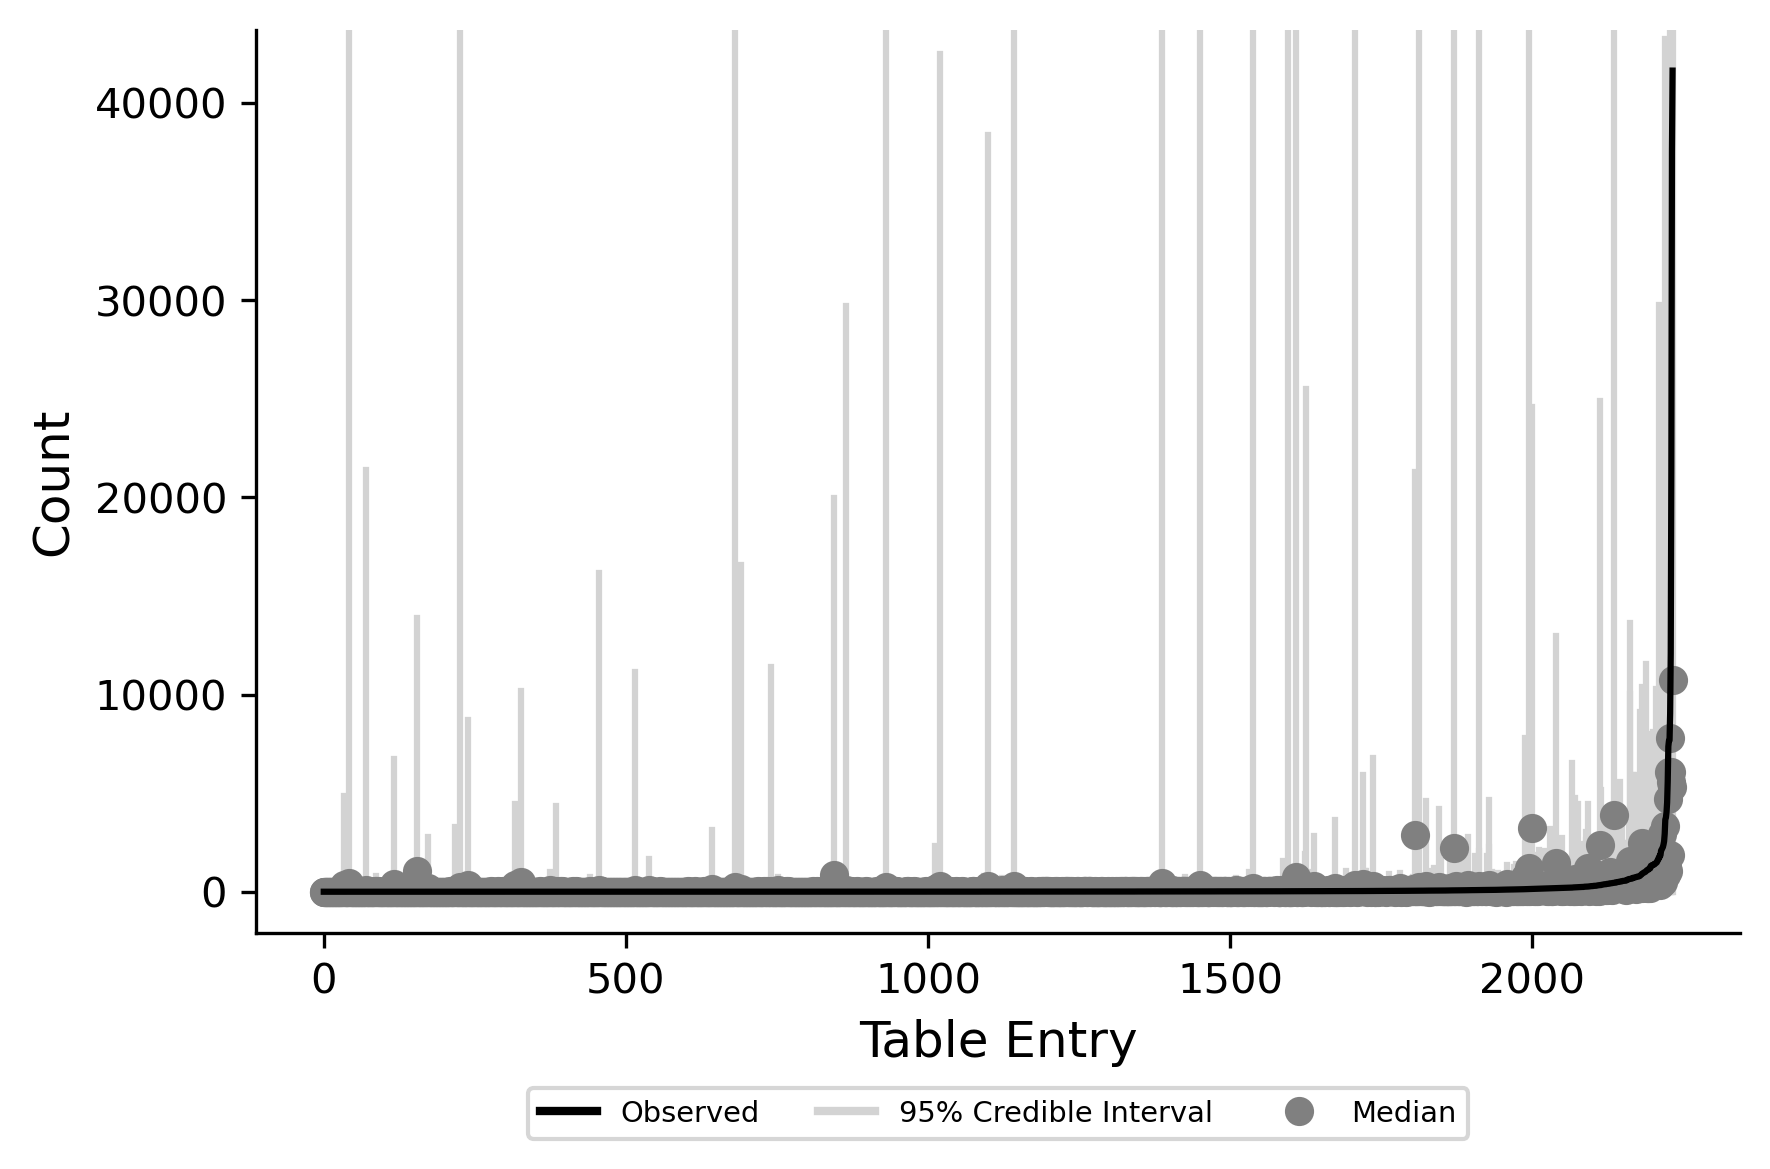

In [15]:
import birdman.visualization as viz
import matplotlib.pyplot as plt

viz.plot_posterior_predictive_checks(inference);

This model seems to do an okay job of predicting counts from metadata.

### Comparing to a null model

Similarly to Songbird we can compare our fitted regression model to a "null" model with only an intercept.

In [16]:
%%capture

from birdman import NegativeBinomial

nb_null = NegativeBinomial(
    table=filt_tbl,
    formula="1",
    metadata=metadata,
    num_iter=100,
    chains=4
)
nb_null.compile_model()
nb_null.fit_model()

In [17]:
inference_null = nb_null.to_inference()

We can look at use `birdman.diagnostics.loo` again to see how our predictive power is with this null model.

In [18]:
diag.loo(inference_null, pointwise=True)

Computed from 400 posterior samples and 2233 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -8204.70   105.93
p_loo      144.88        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2206   98.8%
 (0.5, 0.7]   (ok)         20    0.9%
   (0.7, 1]   (bad)         6    0.3%
   (1, Inf)   (very bad)    1    0.0%

We see a lower value of `elpd_loo`, indicating that this null model has less predictive power than our regression model.

Another thing we can do is use the `arviz.compare` function to compare multiple models. This function takes a dictionary in the form of `{"model_1": InferenceObject, ...}` and outputs a table where the models are ranked from "best" at the top to "worst" at the bottom.

In [19]:
import arviz as az

az.compare({"null": inference_null, "model": inference})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model,0,-8057.047377,318.309078,0.000000,0.794809,104.656839,0.000000,True,log
null,1,-8204.699362,144.884394,147.651985,0.205191,105.932653,25.500515,True,log


We see that indeed our regression model is at the top. We can also compare the difference in `elpd` relative to the standard error to get a rough idea of how much better this model is.

In [20]:
(-8057.047377 - -8204.699362) / 104.656839

1.4108202236071692

Looks like this model is about 1.4 SE above the null. Not bad!

## Analyzing differentials

We are now ready to use our fitted parameters for further analysis.

We can now plot our parameter estimates similarly to how we would do a rank-plot in Qurro. However, since in the Bayesian framework each parameter has a distribution, we also include the standard deviation of these parameter estimates.

In [21]:
from birdman.transform import posterior_alr_to_clr

inference.posterior = posterior_alr_to_clr(
    inference.posterior,
    alr_params=["beta_var"],
    dim_replacement={"feature_alr": "feature"},
    new_labels=nb.feature_names
)

In [22]:
nb.colnames

Index(['Intercept', 'C(diet, Treatment('Control'))[T.DIO]',
       'C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]',
       'C(diet, Treatment('Control'))[T.DIO]:C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]'],
      dtype='object')

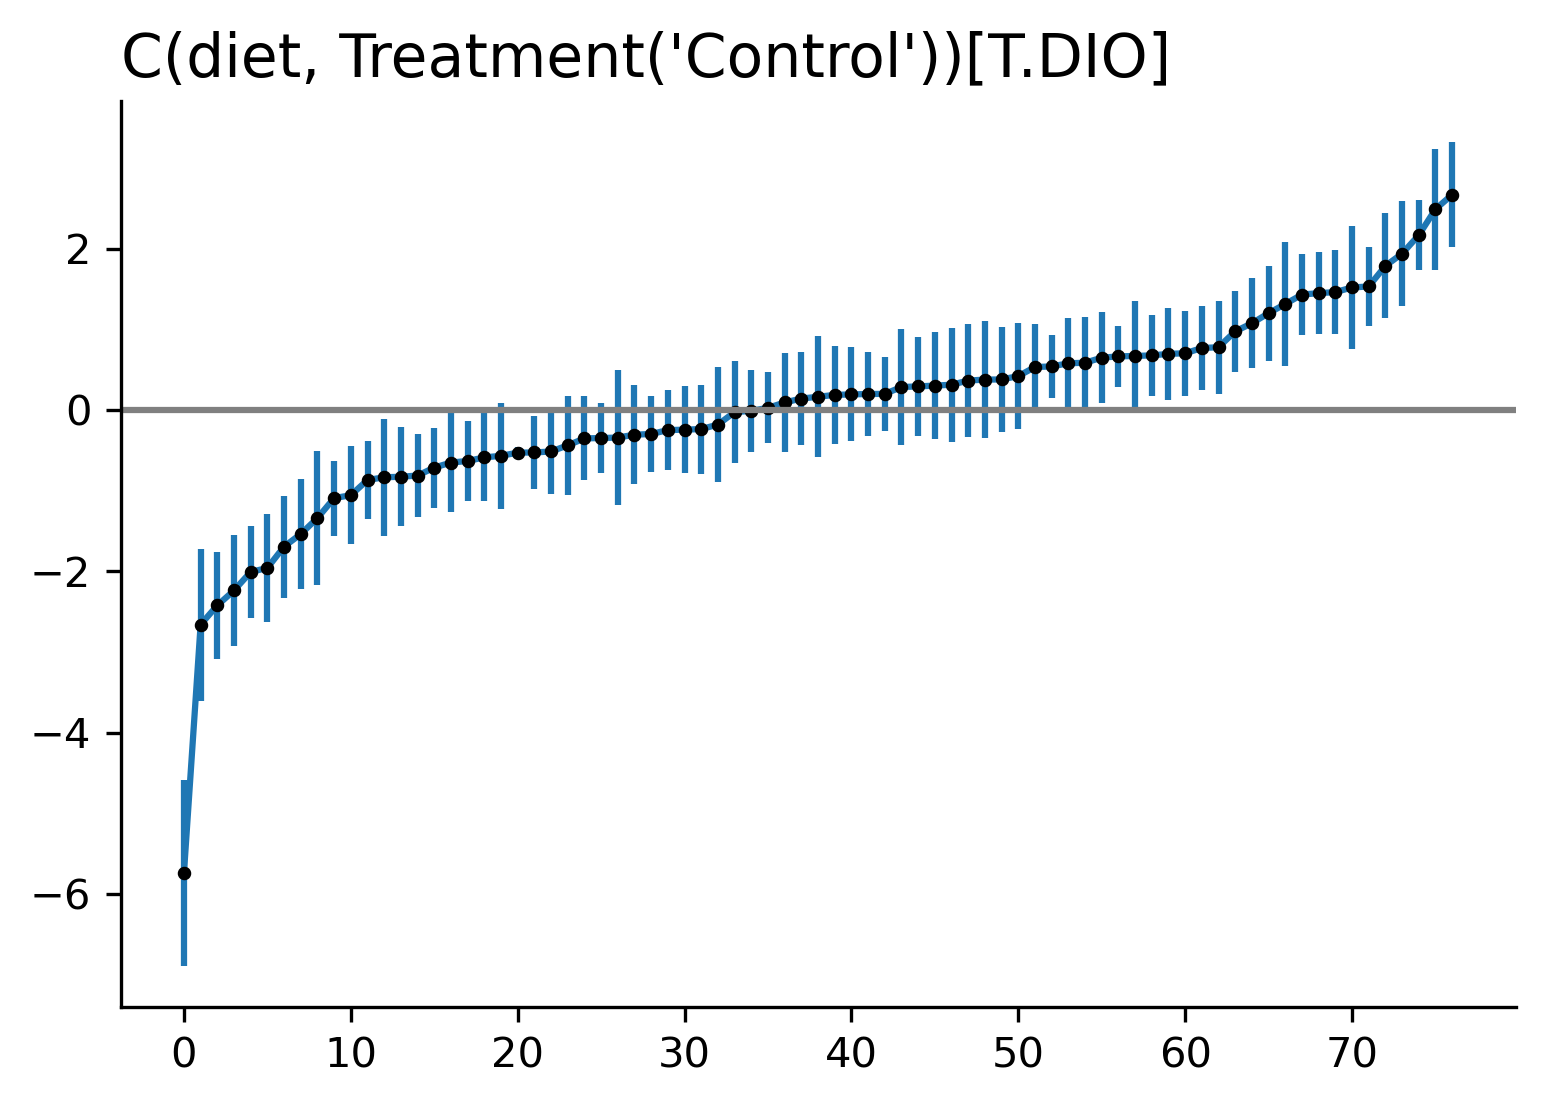

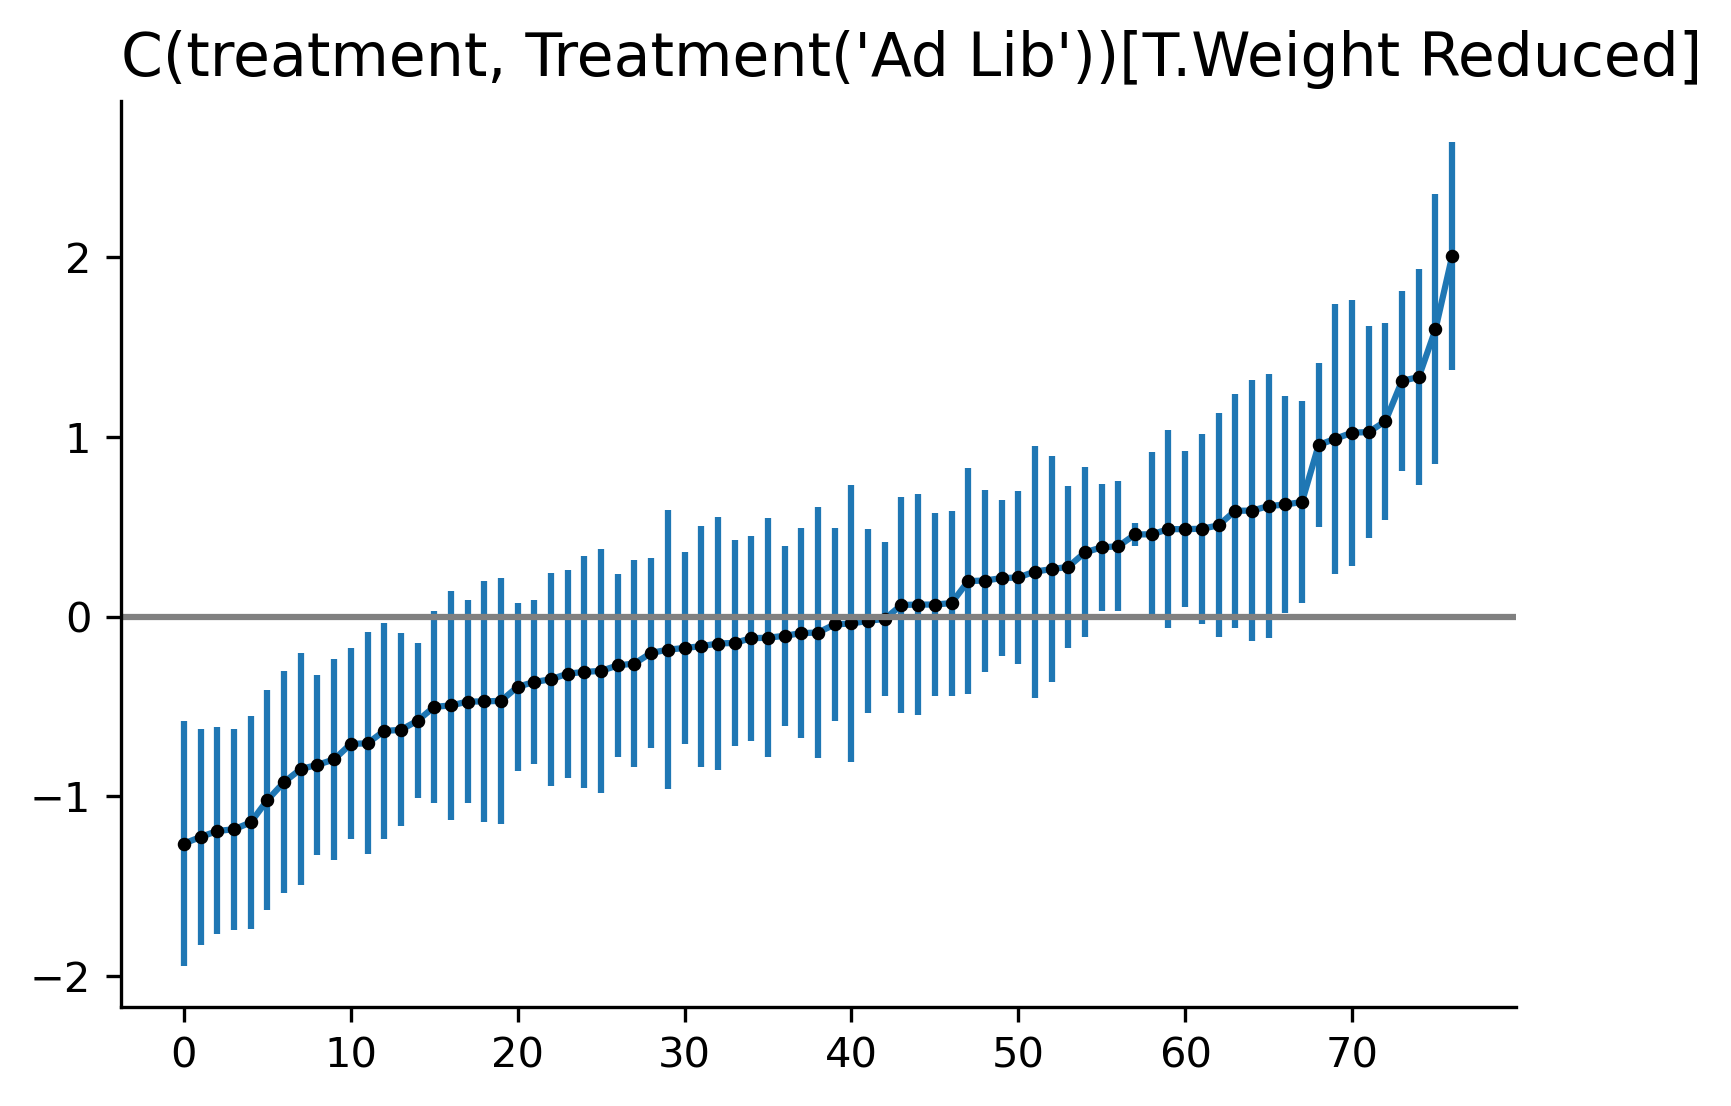

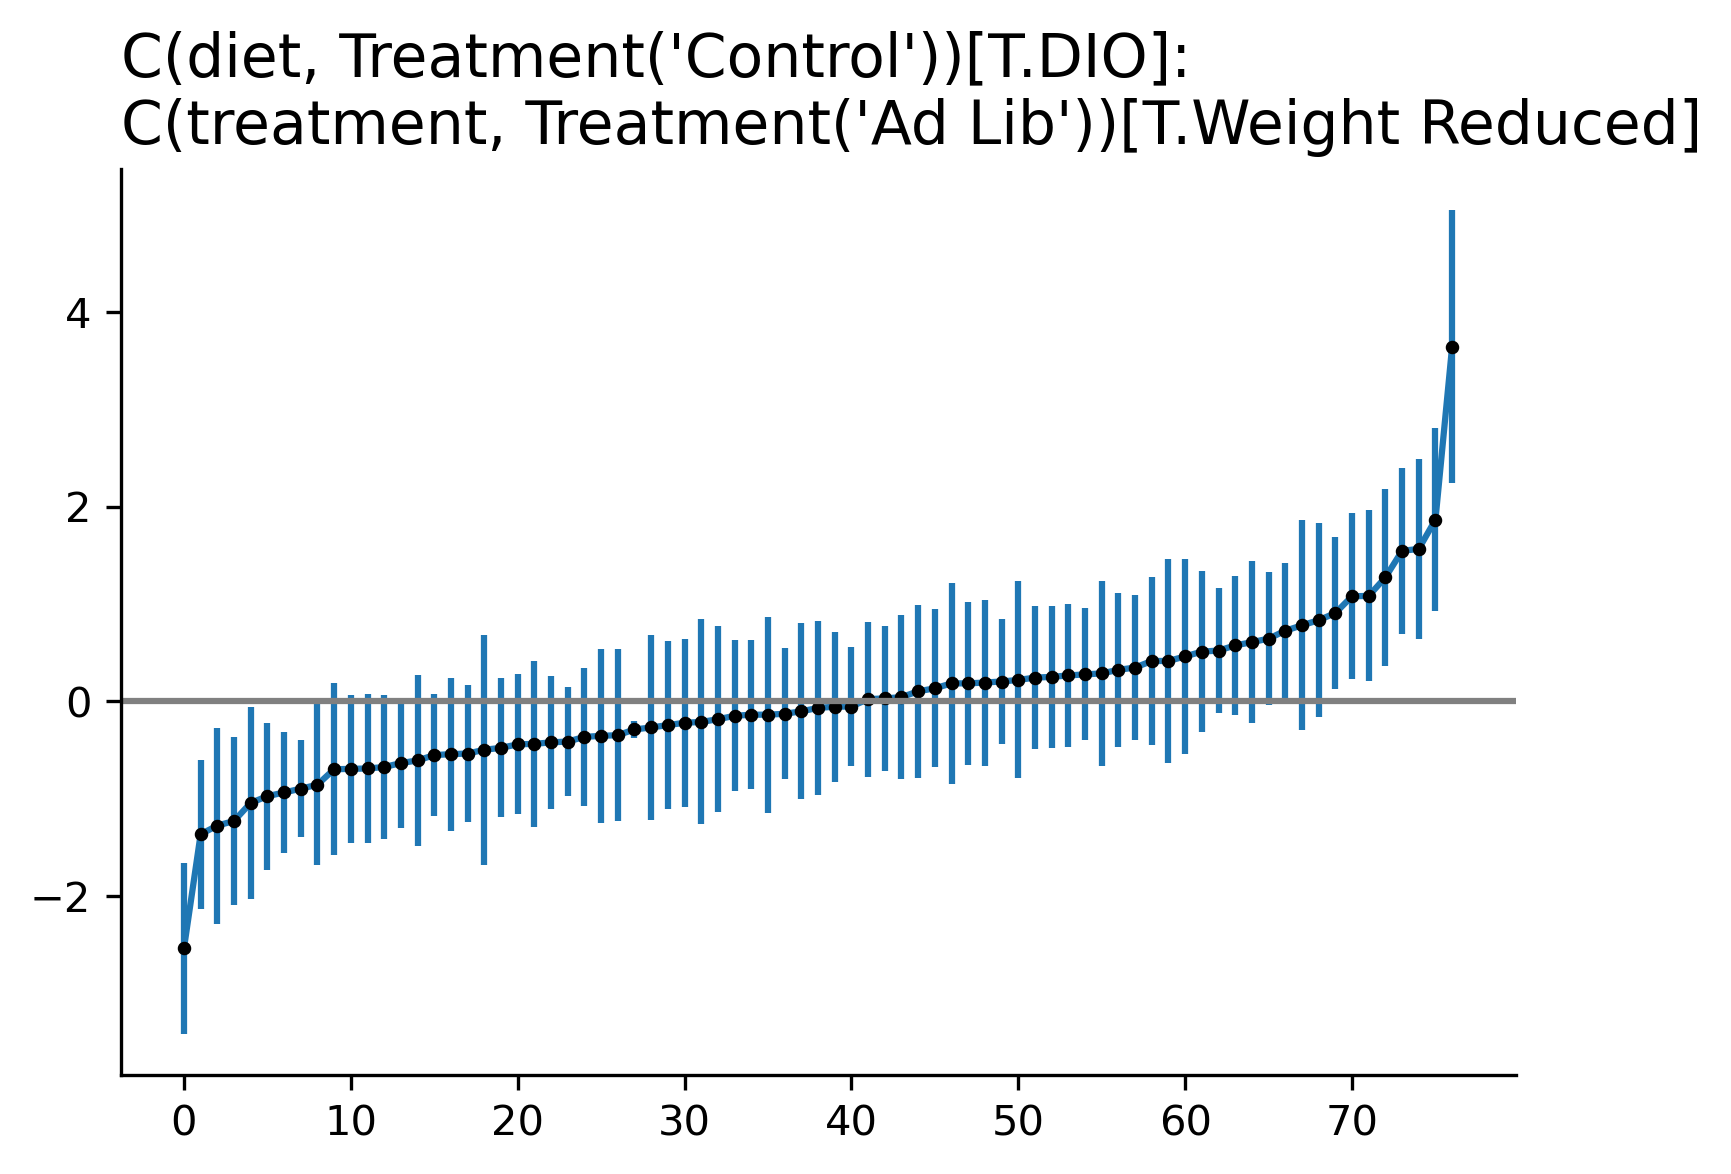

In [23]:
for col in nb.colnames[1:]:
    ax = viz.plot_parameter_estimates(
        inference,
        parameter="beta_var",
        coords={"covariate": col}
    )
    ax.set_title(":\n".join(col.split(":")))
    ax.axhline(y=0, color="gray")

We can use these differentials in the same ways as Songbird. Let's focus on the diet differentials - first we have to sort the features by their means across all chains and draws. This is fairly straightforward using `xarray`-style indexing.

In [24]:
diet_diffs = inference.posterior["beta_var"].sel({"covariate": "C(diet, Treatment('Control'))[T.DIO]"})
diet_diffs = diet_diffs.stack(mcmc_sample=("chain", "draw"))
diet_diffs_means = diet_diffs.mean(dim="mcmc_sample")
diet_diffs_means = diet_diffs_means.sortby(diet_diffs_means)
diet_diffs_means

<xarray.DataArray 'beta_var' (feature: 77)>
array([-5.73694892, -2.65988109, -2.4219365 , -2.23708606, -2.00739175,
       -1.9573763 , -1.69342822, -1.53772343, -1.33882338, -1.09196751,
       -1.05590138, -0.86744068, -0.83328258, -0.82724836, -0.81196281,
       -0.7135843 , -0.65096482, -0.6316501 , -0.58691858, -0.56759943,
       -0.52819507, -0.52580754, -0.51376801, -0.43769074, -0.35128673,
       -0.34720449, -0.34082285, -0.30568045, -0.29715427, -0.24836883,
       -0.24346562, -0.23557318, -0.18048565, -0.02537629, -0.00989158,
        0.02788562,  0.09380669,  0.142793  ,  0.16447638,  0.18803242,
        0.1936418 ,  0.19895287,  0.20065998,  0.28541747,  0.29322137,
        0.30317563,  0.31384448,  0.36595709,  0.37729278,  0.37940998,
        0.42116538,  0.53334287,  0.54078781,  0.57996696,  0.58657954,
        0.64947155,  0.66508215,  0.67095088,  0.67743187,  0.69672586,
        0.70374091,  0.76906979,  0.77883749,  0.97571642,  1.07582325,
        1.20113236,  1.31475314,  1.43184984,  1.44930872,  1.46225464,
        1.51979415,  1.53214966,  1.78738834,  1.93900751,  2.16822761,
        2.49023848,  2.67052281])
Coordinates:
  * feature    (feature) object '230759' '193831' ... '1684221' '258522'
    covariate  <U36 "C(diet, Treatment('Control'))[T.DIO]"

### Plotting log-ratios

Finally, we'll calculate log-ratios using autoselected OTUs. We'll take the top and bottom 5 OTUs to use as our numerator and denominator respectively.

In [25]:
import numpy as np

def log_ratio(table, top_feats, bot_feats):
    num_df = table.loc[:, top_feats].sum(axis=1).to_frame()# + 1
    num_df.columns = ["num"]
    num_df = num_df[num_df["num"] > 0]
    denom_df = table.loc[:, bot_feats].sum(axis=1).to_frame()# + 1
    denom_df.columns = ["denom"]
    denom_df = denom_df[denom_df["denom"] > 0]
    lr_df = num_df.join(denom_df, how="inner")
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"])
    return lr_df

In [26]:
bottom_otus = diet_diffs_means[:5].coords["feature"].values
top_otus = diet_diffs_means[-5:].coords["feature"].values

lr_df = log_ratio(filt_tbl_df.T, top_otus, bottom_otus).join(metadata, how="inner")
print(lr_df.shape)
lr_df.head()

(28, 59)


,num,denom,log_ratio,adiponectin,altitude,anonymized_name,b_cell_function_measure,body_habitat,body_product,body_site,...,saa3,sample_type,slc25a,t3,t4,title,tnfa,total_ee,total_number_of_synapses,treatment
107.CM04,415.0,1248.0,-1.101019,23.55,0,sample03,280.7,UBERON:feces,UBERON:feces,UBERON:feces,...,2.24,XXQIITAXX,1.01,15.30,57.87,Leptin levels correlate with the composition o...,1.17,11.70,19.06,Weight Reduced
107.CM10,1889.0,223.0,2.136631,31.19,0,sample11,222.5,UBERON:feces,UBERON:feces,UBERON:feces,...,1.05,XXQIITAXX,0.87,38.90,56.13,Leptin levels correlate with the composition o...,2.22,13.93,15.82,Ad Lib
107.CM19,1148.0,50976.0,-3.793334,22.85,0,sample25,93.7,UBERON:feces,UBERON:feces,UBERON:feces,...,0.00,XXQIITAXX,0.66,8.80,50.95,Leptin levels correlate with the composition o...,1.67,12.28,14.27,Ad Lib
107.CM23,167.0,37841.0,-5.423155,14.35,0,sample27,140.0,UBERON:feces,UBERON:feces,UBERON:feces,...,0.01,XXQIITAXX,0.59,54.04,42.76,Leptin levels correlate with the composition o...,2.07,12.43,20.92,Ad Lib
107.CM28,20.0,1205.0,-4.098503,40.49,0,sample21,183.8,UBERON:feces,UBERON:feces,UBERON:feces,...,0.15,XXQIITAXX,0.49,13.42,43.39,Leptin levels correlate with the composition o...,0.80,7.37,30.64,Weight Reduced


We'll now plot these log-ratios and compare them by diet.

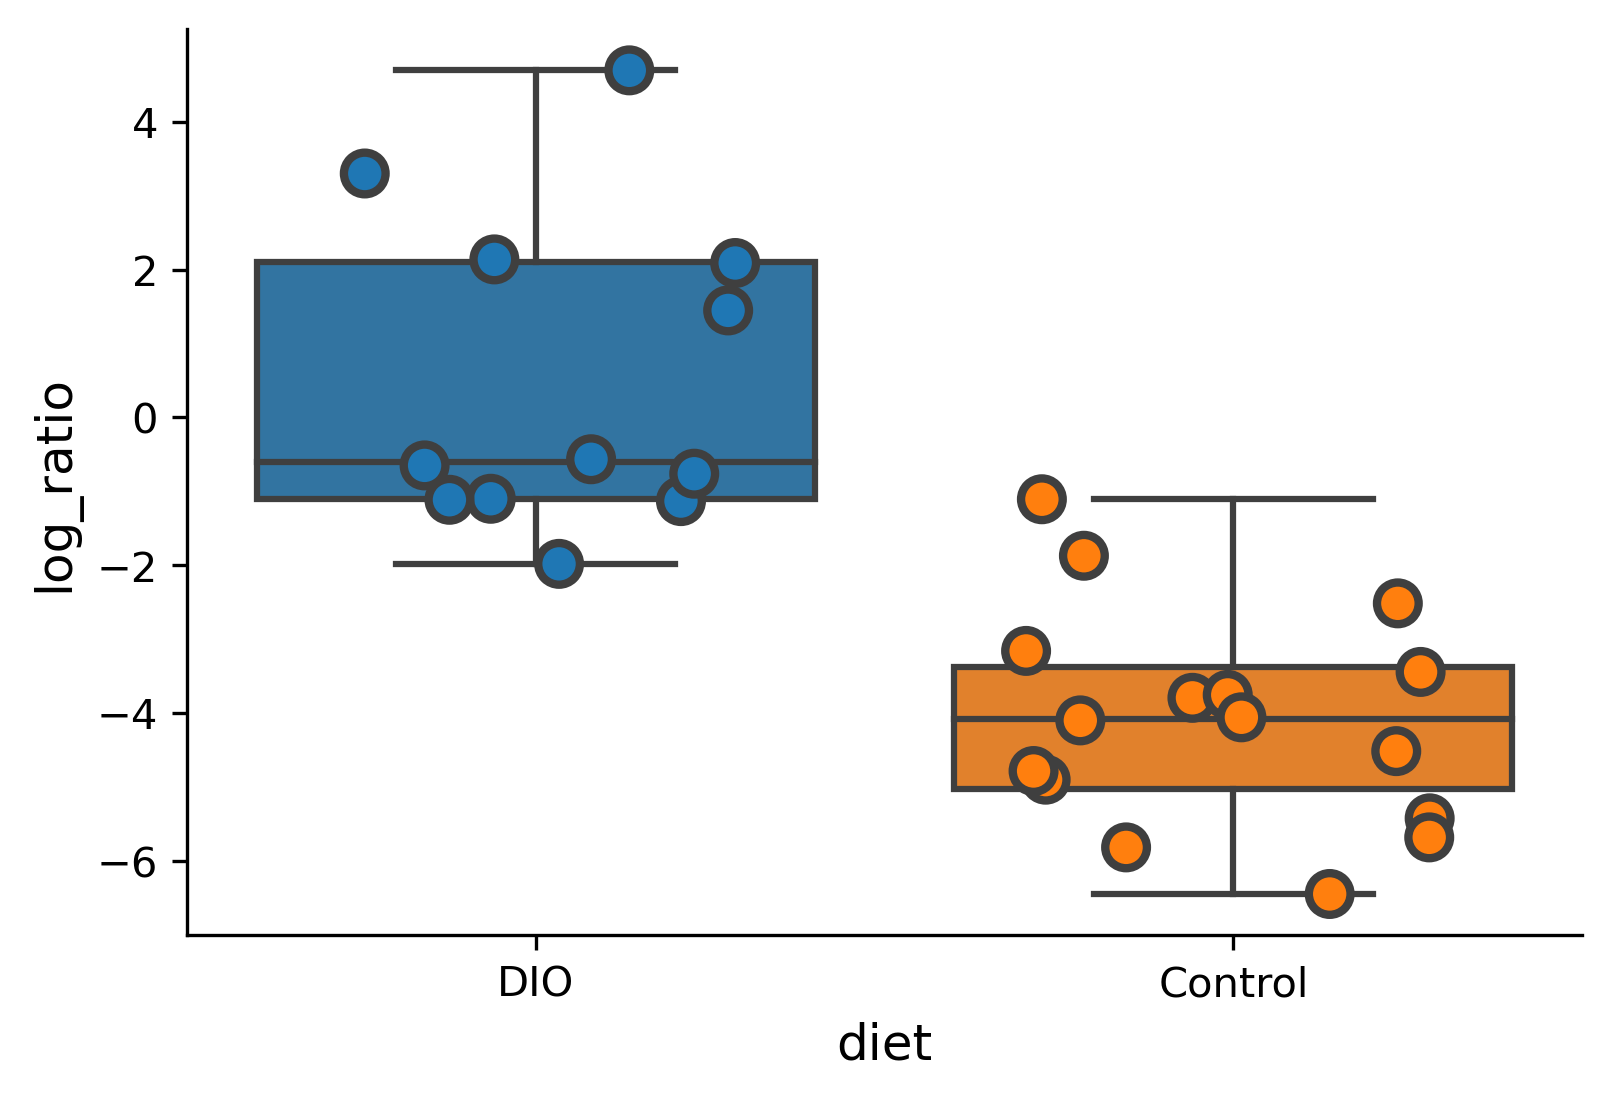

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

args = {
    "data": lr_df,
    "x": "diet",
    "y": "log_ratio"
}

sns.boxplot(**args)
sns.stripplot(**args, linewidth=2, size=10, jitter=0.3)

plt.show()

In [28]:
import scipy.stats as ss

dio_samples = lr_df.query("diet == 'DIO'")["log_ratio"]
control_samples = lr_df.query("diet == 'Control'")["log_ratio"]

print(ss.mannwhitneyu(dio_samples, control_samples))

MannwhitneyuResult(statistic=188.0, pvalue=2.1589841841116642e-05)


Indeed, this log-ratio separates the samples well by diet.

### Statistical tests

We plan to implement several statistical tests to help guide users in their analysis in determining covariates/features of interest. One such option is the Hotelling $t^2$-test on individual covariates to see if they are centered around 0 (in ALR coordinates).

In [29]:
from birdman.stats import hotelling_ttest

hotelling_ttest(inference, {"covariate": "C(diet, Treatment('Control'))[T.DIO]"})

(434.73755654521096, 1.1102230246251565e-16)

### Summarizing

We may want to save the differentials in tabular format for downstream analysis. We can summarize each feature by taking the mean of the posterior distribution. We can do this easily with the `summarize_posterior` function in BIRDMAn. The means are calculated by default but we can also calculate the standard deviation just as easily.

In [30]:
from birdman.summary import summarize_posterior

summ_means = summarize_posterior(inference.posterior, "beta_var")
summ_means.columns = [x + "_mean" for x in summ_means.columns]
summ_stds = summarize_posterior(inference.posterior, "beta_var", estimator="std")
summ_stds.columns = [x + "_std" for x in summ_stds.columns]

summ_df = pd.concat([summ_means, summ_stds], axis=1)
summ_df.head()

,Intercept_mean,"C(diet, Treatment('Control'))[T.DIO]_mean","C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]_mean","C(diet, Treatment('Control'))[T.DIO]:C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]_mean",Intercept_std,"C(diet, Treatment('Control'))[T.DIO]_std","C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]_std","C(diet, Treatment('Control'))[T.DIO]:C(treatment, Treatment('Ad Lib'))[T.Weight Reduced]_std"
feature,,,,,,,,
193358,5.973868,-0.528195,0.457452,-0.288822,0.045675,0.071277,0.064878,0.091214
4465746,2.359666,0.377293,0.065117,0.286920,0.442848,0.728221,0.600781,0.949312
4430921,-1.083593,-0.833283,-0.088493,1.865766,0.464448,0.726940,0.696268,0.942773
260859,-1.792018,1.431850,-0.494344,-0.055308,0.366695,0.499573,0.637038,0.771301
192557,-0.081276,-0.713584,-0.824521,0.643660,0.307847,0.495731,0.499313,0.686688


# Wrapping up

We hope you learned a bit about using BIRDMAn for differential abundance! There's definitely a lot to digest here and we only scratched the surface of the possibilities. You may also want to view the traceplots for individual parameters to see if the chains have converged or view the [effective sample size](https://mc-stan.org/docs/2_26/reference-manual/effective-sample-size-section.html).

Check out the other notebook in this repository for an example of how to write and fit your own Stan model using BIRDMAn!